In [59]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
csv_path = '/content/drive/MyDrive/[04] College/[04] Year/SEM 2/CS4168/LAB 4/seeds.csv'
df = pd.read_csv(csv_path)
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


# Some EDA of seeds dataset

In [62]:
df.isna().sum()

,0
area,0
perimeter,0
compactness,0
length of kernel,0
width of kernel,0
asymmetry coefficient,0
length of kernel groove,0
type,0


There is no missing values in the dataset, nice

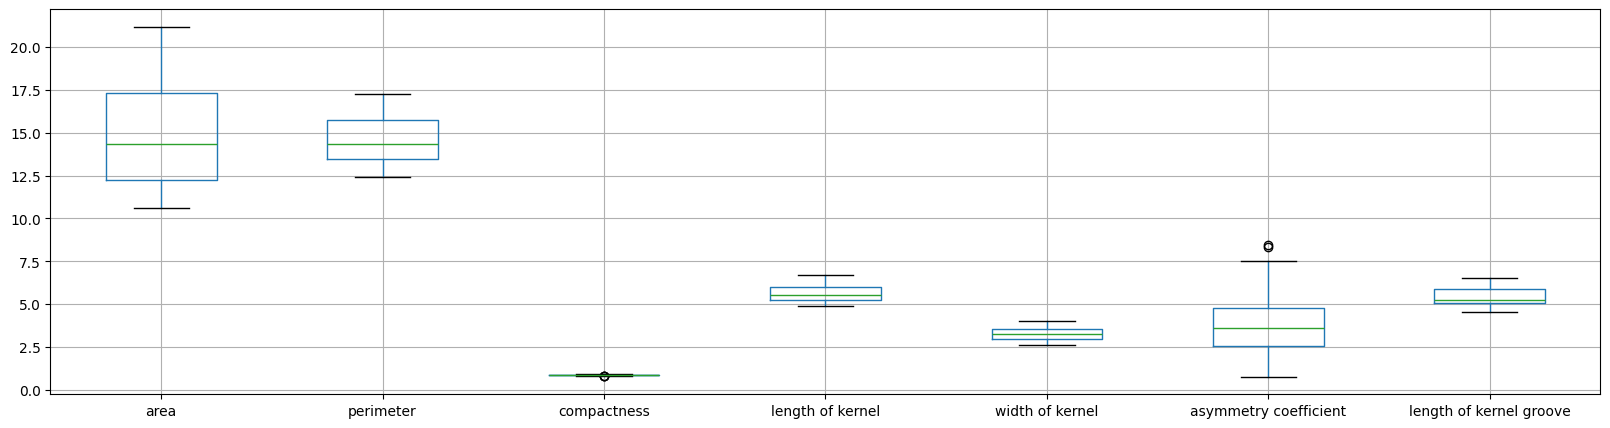

In [63]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

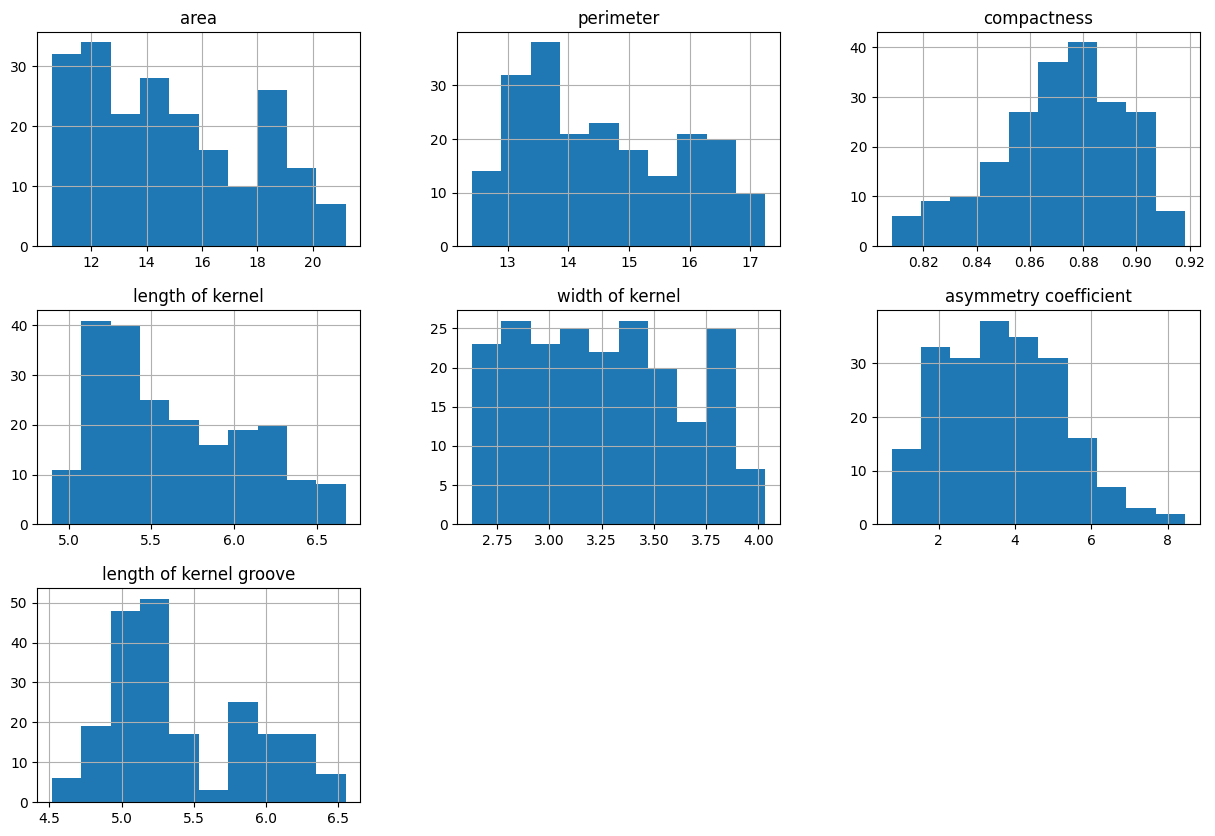

In [64]:
X.hist(bins=10, figsize=(15, 10))
plt.show()

Box plot and Historgram used to see the outliers and skewness of data which will be used later

In [65]:
df['type'].value_counts()

,count
type,
1,70
2,70
3,70


Type has 3 classes so we could use this for binary classifcation

# Data preperation

In [66]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

,count
type,
0,140
1,70


In [67]:
X = df.drop(columns=['type'])  # Features
y = df['type']  # Target

In [68]:
# Group 1
columns_no_outliers = ['compactness']

# Group 2
columns_outliers_and_zeros = ['asymmetry coefficient']

# Group 3
columns_outliers_no_zeros = [col for col in X.columns
                             if col not in columns_no_outliers and col not in columns_outliers_and_zeros]

# verify the correct columns are selected
print(columns_outliers_no_zeros)
print(len(columns_outliers_no_zeros))

['area', 'perimeter', 'length of kernel', 'width of kernel', 'length of kernel groove']
5


Bulding the preprocessing pipeline

In [69]:
# Transformation for outliers with NO 0s (log transform + robust scaling)
outliers_no_zeros_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(np.log)),
    ("scaler", RobustScaler())
])

# Transformation for outliers WITH 0s (cubic root transform + robust scaling)
outliers_and_zeros_pipeline = Pipeline([
    ("cubic_root_transform", FunctionTransformer(np.cbrt)),
    ("scaler", RobustScaler())
])

# Transformation for no outliers (cubic root transform)
no_outliers_pipeline = FunctionTransformer(np.cbrt)

preprocess_pipeline = ColumnTransformer([
    ("outliers_no_zeros", outliers_no_zeros_pipeline, columns_outliers_no_zeros),
    ("outliers_and_zeros", outliers_and_zeros_pipeline, columns_outliers_and_zeros),
    ("no_outliers", no_outliers_pipeline, columns_no_outliers)
], remainder="passthrough")  # Keep any remaining columns as is

Split dataset into train and test

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model training

# SVM

Train SVM Like how was done in example to find best parameters

In [71]:
# Create the pipeline with preprocessing and SVM
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [72]:
# Display pipeline structure
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel groove']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['asymmetry coefficient']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['compactness'])])),
                ('svm', SVC(probability=True))])

In [73]:
# parameter grid for SVM
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

# Grid Search Cross Validation
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  # Training happens here!

# Print Best SVM Results
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store best model and parameters
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.952:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


# Random Forest

Same just for Random forest

In [74]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

In [75]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel groove']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['asymmetry coefficient']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['compactness'])])),
                ('rf', RandomForestClassifier())])

In [76]:
# parameter grid for Random forest
param_grid = {
    'rf__n_estimators' : [10, 50, 100],
    'rf__max_depth': [None, 10, 20]
}

# Perform Grid Search Cross Validation
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  # Training happens here!

# Print Best Random Forest Results
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store best model and parameters
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.940:
Best parameters:  {'rf__max_depth': None, 'rf__n_estimators': 10}


# Next one MLP and compare

Pipelie like before for MlP

In [77]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier(max_iter=1000))])

In [78]:
# parameter grid for MLP
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Perform Grid Search Cross Validation
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  # Training happens here!

# Print Best MLP Results
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store best model and parameters
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.952:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate': 'constant'}


# Compare classfiers on test set

Same as lab, just adding in MLP I did

In [79]:
# Generate evenly spaced FPR values for plotting ROC curves
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [80]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [81]:
# Evaluate all models
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

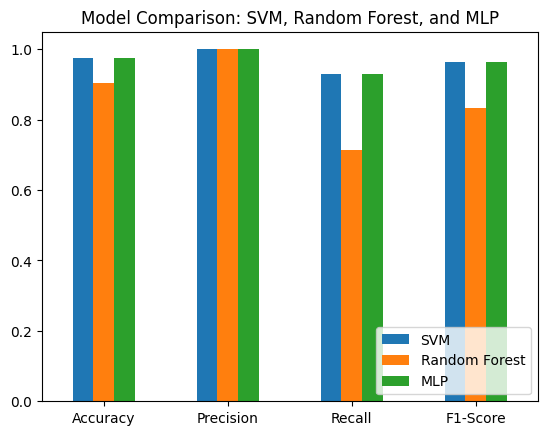

In [82]:
# Store results in a DataFrame
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])

index = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)

# Plot bar chart
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.title("Model Comparison: SVM, Random Forest, and MLP")
plt.show()


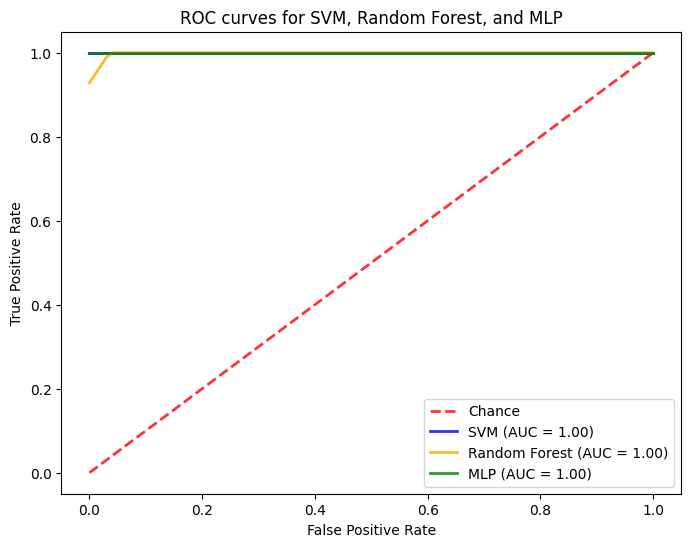

In [83]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0, :], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0, :], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0, :], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for SVM, Random Forest, and MLP')
plt.legend(loc="lower right")
plt.show()


In comparing the models, I used what was in the lab:

Accuracy: Measures overall correctness.
Precision: Measures how many predicted positives are actually positive.
Recall: Measures how many actual positives were correctly identified.
F1-Score: Balances precision and recall.
ROC Curve & AUC: Measures classifier ability to distinguish between classes.



Looking more in depth:
SVM and MLP achieved the highest overall performance in accuracy, precision, recall, and F1-score. Random Forest performed slightly lower in recall, indicating it may miss some positive cases. MLP slightly outperforms the other models in recall, meaning it detects more positive cases.


All three models achieved an AUC of 1.00, suggesting perfect separation between classes. SVM and MLP achieved nearly identical ROC curves, meaning they provide optimal classification.


So in choosing best model to save, I want with MLP just because it has:

- Slightly better recall, meaning fewer false negatives.
- Consistently high performance across all metrics.

# Train final Model on full dataset and save

In [56]:
# Function to remove 'mlp__' from parameter names
def transform(params_dict):
    return {key.replace('mlp__', ''): value for key, value in params_dict.items()}

# Create the final pipeline with the best parameters
pipe = make_pipeline(preprocess_pipeline, MLPClassifier(**transform(MLP_best_params), max_iter=1000))

# Train the final model on the full dataset
final_model = pipe.fit(X, y)


In [57]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))